# константы

In [1]:
data_dir = '/home/admin/notebooks/data_mb/'

coco_files_dir = data_dir + 'coco/metadata_for_merge/'
merged_coco_filename = data_dir + 'coco/merged.json'
image_dir = data_dir + 'images/'

# обучение
train_dir = data_dir + 'train/'
train_image_dir = train_dir + 'images/'
train_annotations_filename = train_dir + 'train_annotations.json'
train_binary_mask_filename = train_dir + 'all_groundtruth_binary_mask.npz'
train_config_filename = train_dir + "config.yaml"

# валидация
val_dir = data_dir + 'val/'
val_image_dir = val_dir + 'images/'
val_annotations_filename = val_dir + 'val_annotations.json'
val_binary_mask_filename = val_dir + 'val_binary_mask.npz'
val_predict_binary_mask_filename = val_dir + 'val_predict_binary_mask.npz'

output_dir = '/home/admin/notebooks/output_mb/'
model_final_filename = output_dir + 'model_final.pth'
metrics_filename = output_dir + 'metrics.json'


# мёрж COCO файлов и исправление путей к образам

In [2]:
from prepare_data import get_coco_files,save_to_file,merge,fix_image_paths

coco_files = get_coco_files(coco_files_dir)
merged_coco_obj = merge(coco_files)
fix_image_paths(merged_coco_obj, image_dir)
save_to_file(merged_coco_obj, merged_coco_filename)


['/home/admin/notebooks/data_mb/coco/metadata_for_merge/metric_book_2-4.json', '/home/admin/notebooks/data_mb/coco/metadata_for_merge/metric_book_1-3.json']


  0%|          | 0/2 [00:00<?, ?it/s]

# подготовка данных для обучения и валидации

In [3]:
from prepare_data import prepare_train_and_val_coco_files,save_to_file,copy_images

annotations_train, annotations_val = prepare_train_and_val_coco_files(merged_coco_filename)

save_to_file(annotations_train, train_annotations_filename)
save_to_file(annotations_val, val_annotations_filename)

# Скопируем изображения для обучения и валидации
copy_images(annotations_train, image_dir, train_image_dir)
copy_images(annotations_val, image_dir, val_image_dir)



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

# подготовка бинарных масок

In [4]:
from prepare_data import prepare_masks
import numpy as np

# сохраняем маски в файл        
all_binary_mask_dict = prepare_masks(merged_coco_filename, image_dir)
np.savez_compressed(train_binary_mask_filename, **all_binary_mask_dict)

val_binary_mask_dict = prepare_masks(val_annotations_filename, val_image_dir)
np.savez_compressed(val_binary_mask_filename, **val_binary_mask_dict)

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

# Обучение

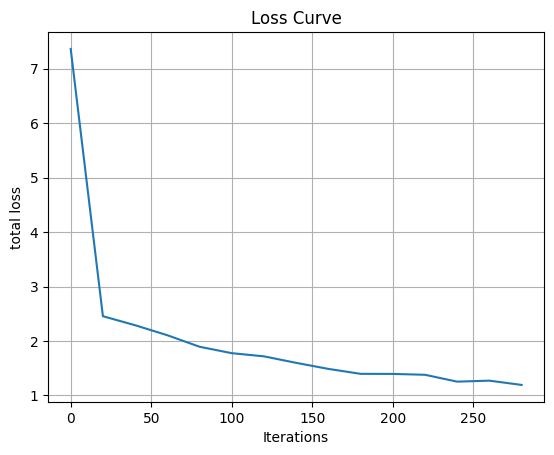

{'rpn/num_pos_anchors': (128.0, 280), 'rpn/num_neg_anchors': (128.0, 280), 'roi_head/num_fg_samples': (128.0, 280), 'roi_head/num_bg_samples': (381.14285714285717, 280), 'fast_rcnn/cls_accuracy': (0.8778058361391695, 280), 'fast_rcnn/fg_cls_accuracy': (0.6166294642857143, 280), 'fast_rcnn/false_negative': (0.3833705357142857, 280), 'mask_rcnn/accuracy': (0.8832417034894315, 280), 'mask_rcnn/false_positive': (0.13477961704593341, 280), 'mask_rcnn/false_negative': (0.10302969502407705, 280), 'data_time': (2.6158803709986387, 280), 'total_loss': (1.1929332204163074, 280), 'loss_cls': (0.29756778478622437, 280), 'loss_box_reg': (0.37989217042922974, 280), 'loss_mask': (0.265571266412735, 280), 'loss_rpn_cls': (0.047929052263498306, 280), 'loss_rpn_loc': (0.20197294652462006, 280), 'lr': (0.0028071999999999997, 280), 'time': (5.060581316000025, 280), 'eta_seconds': (100.58505480999884, 279)}
Осталось до окончания  0:01:40.585055
[08/04 16:37:26 d2.utils.events]:  eta: 0:00:00  iter: 299  to

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0.80107

In [2]:
from training import init_datasets,init_train_config,train_model
from training import init_predict_config,predict
import numpy as np
from detectron2.engine import launch
from detectron2.utils.logger import setup_logger
from training import evaluate
setup_logger()

!export CUDA_VISIBLE_DEVICES=0,1
!export NGPU=2

init_datasets(
    train_annotations_filename = train_annotations_filename,
    train_image_dir = train_image_dir,
    val_annotations_filename = val_annotations_filename,
    val_image_dir = val_image_dir)

cfg = init_train_config(train_config_filename, output_dir)

# обучение
# train_model(cfg) 
# или:
launch(train_model, num_gpus_per_machine=1, args=(cfg,))
# не работает multy gpu: launch(train_model, num_gpus_per_machine=2, args=(cfg,))


# построим предсказания на валидационном датасете и сохраним бинарные маски в файл
cfg = init_predict_config(train_config_filename, output_dir)
val_predictions_binary_mask_dict = predict(cfg, val_annotations_filename, val_image_dir)
np.savez_compressed(val_predict_binary_mask_filename, **val_predictions_binary_mask_dict)


# посчитаем метрику F1-score на валидационном датасете
evaluate(train_binary_mask_filename, val_predict_binary_mask_filename)


# Оценка качества

In [3]:
from training import evaluate

evaluate(train_binary_mask_filename, val_predict_binary_mask_filename)

  0%|          | 0/15 [00:00<?, ?it/s]

0.80107

# Сохранение результатов

In [4]:
from training import save_results

save_results(output_dir, files = [
    train_annotations_filename,
    train_config_filename,
    val_annotations_filename,
    model_final_filename,
    metrics_filename,
    val_predict_binary_mask_filename
])


copy file: /home/admin/notebooks/data_mb/train/train_annotations.json
copy file: /home/admin/notebooks/data_mb/train/config.yaml
copy file: /home/admin/notebooks/data_mb/val/val_annotations.json
copy file: /home/admin/notebooks/output_mb/model_final.pth
copy file: /home/admin/notebooks/output_mb/metrics.json
copy file: /home/admin/notebooks/data_mb/val/val_predict_binary_mask.npz
